# Revised TF Record Implementation

In [1]:
import sys
sys.path.append('../')
import pymongo
import tensorflow as tf
import numpy as np
import chess
from multiprocessing import Pool
import csv
import os
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sqlalchemy.orm import  Session
from tqdm import tqdm
from Chess_Model.src.model.classes.cnn_scorer import boardCnnEval
from joblib import load
import math
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
from pymongo import MongoClient

current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)


C:\Users\ethan\git\Full_Chess_App


# Importing my stuff

In [2]:
from Chess_Model.src.model.config.config import Settings
from Chess_Model.src.model.classes.sqlite.dependencies import  fetch_one_game_position, fetch_all_game_positions_rollup,get_rollup_row_count,board_to_GamePostition
from Chess_Model.src.model.classes.sqlite.models import GamePositions
from Chess_Model.src.model.classes.sqlite.database import SessionLocal

# Constants

In [3]:
tfrecord_file_name = 'combined_data.tfrecord'
metadata_key = 'metadata'
bitboards_key = 'positions_data'
results_key = 'game_results'
feature_description = {
    'bitboards': tf.io.FixedLenFeature([], tf.string),
    'metadata': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string),
}
scalarFile = './Chess_Model/src/model/data/scaler.joblib'
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")

# Create or switch to a database
db = client["mydatabase"]

# Create or switch to a collection
collection = db["mycollection"]

# Step 1: Prepare multiple bitboards

In [4]:
bitboards = [np.random.randint(2, size=(8, 8), dtype=np.int8) for _ in range(3)]  # 3 bitboard examples
bitboards

[array([[1, 1, 0, 0, 0, 1, 0, 0],
        [1, 0, 1, 1, 0, 1, 0, 1],
        [0, 1, 0, 1, 0, 0, 1, 1],
        [0, 1, 0, 0, 1, 0, 0, 0],
        [1, 0, 1, 1, 0, 1, 1, 0],
        [1, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1]], dtype=int8),
 array([[1, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 1, 1, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 0],
        [0, 1, 1, 1, 1, 0, 1, 1]], dtype=int8),
 array([[1, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 1, 0],
        [1, 0, 0, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 0, 1]], dtype=int8)]

# Step 2: Prepare metadata and target data

In [5]:
metadata = np.array([11, 15.8, 3.14], dtype=np.float32)  # Example metadata (e.g., date)
target = np.array([1, 0, 1], dtype=np.float32)  # Example target data

# Step 3: Function to serialize tensors

In [6]:
def serialize_tensor(tensor):
    return tf.io.serialize_tensor(tf.convert_to_tensor(tensor, dtype=tensor.dtype))


# Step 4: Serialize each part

In [7]:
bitboards_tensor = tf.stack([tf.convert_to_tensor(board, dtype=tf.int8) for board in bitboards])
serialized_bitboards = tf.io.serialize_tensor(bitboards_tensor)
serialized_metadata = serialize_tensor(metadata)
serialized_target = serialize_tensor(target)


# Step 5: Function to create a bytes feature

In [8]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))


# Step 6: Combine features into a single Example

In [9]:
features = {
'bitboards': _bytes_feature(serialized_bitboards.numpy()),
'metadata': _bytes_feature(serialized_metadata.numpy()),
'target': _bytes_feature(serialized_target.numpy())
}
example = tf.train.Example(features=tf.train.Features(feature=features))


# Step 7: Write the example to a TFRecord file

In [10]:

with tf.io.TFRecordWriter(tfrecord_file_name) as writer:
    writer.write(example.SerializeToString())


In [11]:


# Function to parse a single example
def _parse_function(example_proto):
    # Parse the input `tf.train.Example` proto using the dictionary above.
    example = tf.io.parse_single_example(example_proto, feature_description)
    bitboards = tf.io.parse_tensor(example['bitboards'], out_type=tf.int8)
    metadata = tf.io.parse_tensor(example['metadata'], out_type=tf.float32)
    target = tf.io.parse_tensor(example['target'], out_type=tf.float32)
    return bitboards, metadata, target

# Step 2: Read the TFRecord file
tfrecord_file_name = 'combined_data.tfrecord'
dataset = tf.data.TFRecordDataset([tfrecord_file_name])

# Step 3: Parse the dataset
parsed_dataset = dataset.map(_parse_function)

# Step 4: Iterate over the dataset and process the data
for bitboards, metadata, target in parsed_dataset.take(1):
    print("Bitboards:", bitboards.numpy())  # Access numpy array with .numpy()
    print("Metadata:", metadata.numpy())
    print("Target:", target.numpy())


Bitboards: [[[1 1 0 0 0 1 0 0]
  [1 0 1 1 0 1 0 1]
  [0 1 0 1 0 0 1 1]
  [0 1 0 0 1 0 0 0]
  [1 0 1 1 0 1 1 0]
  [1 0 1 1 0 1 0 0]
  [1 1 0 1 0 1 0 0]
  [0 0 0 0 0 1 0 1]]

 [[1 0 1 0 0 1 0 0]
  [1 0 0 1 1 0 1 1]
  [1 1 1 1 1 0 1 0]
  [1 0 0 0 1 0 1 1]
  [0 0 0 0 0 0 0 1]
  [1 0 0 1 1 0 0 0]
  [0 1 1 0 0 1 0 0]
  [0 1 1 1 1 0 1 1]]

 [[1 1 1 1 1 1 0 0]
  [0 0 0 0 0 0 1 1]
  [1 1 0 0 0 1 0 1]
  [0 0 0 0 1 1 0 0]
  [1 1 1 0 0 1 1 0]
  [1 0 0 1 1 1 1 1]
  [1 0 0 0 1 0 1 1]
  [1 0 1 0 1 1 0 1]]]
Metadata: [11.   15.8   3.14]
Target: [1. 0. 1.]


In [12]:
bitboards.shape

TensorShape([3, 8, 8])

# Generating Data from Game Analyzer

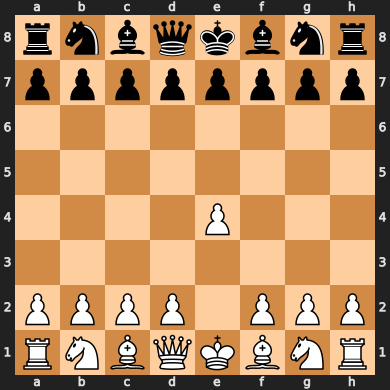

In [13]:
sample = []
with SessionLocal() as db:
    game1 = fetch_one_game_position(db=db)
    sample.append(game1)
    game2 = fetch_one_game_position(db=db)
    sample.append(game2)

dataset = []
evaluator = boardCnnEval()
for game in sample:
    evaluator.setup_parameters_gamepositions(game=game)
    dataset.append(evaluator.get_board_scores_records())
board = chess.Board(game1.piece_positions)
board

In [14]:
print(dataset[0]['positions_data'])
print(dataset[0]['metadata'])
        

{'white advantage positions': array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'black advantage positions': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]), 'castling positions': array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]), 'en passant positions': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'white king check positions': array

In [15]:
def split_board_scores(scores_dict: dict):
    # Collect all values within the nested metadata dictionary
    metadata = list(scores_dict[metadata_key].values())
    # metadata = []
    # for key, value in scores_dict['metadata'].items():
    #     metadata += [value]

    # For positions_data, it's a bit tricky since it looks like it might contain arrays.
    # Assuming you want to keep these arrays intact:
    bitboards = list(scores_dict[bitboards_key].values())
    
    # Collect all values within the game_results dictionary
    game_results = list(scores_dict[results_key].values())
    
    return bitboards, metadata, game_results

In [16]:
bb,md,gr = split_board_scores(dataset[0])
str(md)

'[8, 2, 2, 2, 1, 8, 2, 2, 2, 1, 15, 15, 1, 1, 1, 1, 1, 1, 30, 20, 1.5, 0.6666666666666666, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]'

In [17]:
bb

[array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]),
 array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [18]:
md

[8,
 2,
 2,
 2,
 1,
 8,
 2,
 2,
 2,
 1,
 15,
 15,
 1,
 1,
 1,
 1,
 1,
 1,
 30,
 20,
 1.5,
 0.6666666666666666,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

In [19]:
def serialize_data(scores_dict):

        bb,md,gr = split_board_scores(scores_dict)
        
        bitboards_tensor = tf.stack([tf.convert_to_tensor(board, dtype=tf.int8) for board in bb])
        serialized_bitboards = tf.io.serialize_tensor(bitboards_tensor)
        
        metadata_tensor = tf.convert_to_tensor(md,dtype=tf.float16)
        serialized_metadata = serialize_tensor(metadata_tensor)
        
        target_tensor = tf.convert_to_tensor(gr,dtype=tf.float16)
        serialized_target = serialize_tensor(target_tensor)
        
        return serialized_bitboards, serialized_metadata, serialized_target

In [20]:

def serialize_and_save_dataset(dataset):
    with tf.io.TFRecordWriter(tfrecord_file_name) as writer:
        for data in dataset:
            s_b, s_m, s_t = serialize_data(data)
            features = {
            'bitboards': _bytes_feature(s_b.numpy()),
            'metadata': _bytes_feature(s_m.numpy()),
            'target': _bytes_feature(s_t.numpy())
            }
            example = tf.train.Example(features=tf.train.Features(feature=features))

    
            writer.write(example.SerializeToString())
            
len(dataset)
serialize_and_save_dataset(dataset)

In [21]:
# Function to parse a single example
def _parse_function(example_proto):
    # Parse the input `tf.train.Example` proto using the dictionary above.
    example = tf.io.parse_single_example(example_proto, feature_description)
    bitboards = tf.io.parse_tensor(example['bitboards'], out_type=tf.int8)
    metadata = tf.io.parse_tensor(example['metadata'], out_type=tf.float16)
    target = tf.io.parse_tensor(example['target'], out_type=tf.float16)
    return bitboards, metadata, target
    

In [22]:
def get_parsed_dataset(record_file):
    dataset = tf.data.TFRecordDataset([record_file])
    parsed_dataset = dataset.map(_parse_function,num_parallel_calls=tf.data.AUTOTUNE)
    return parsed_dataset

In [23]:
parsed_data = get_parsed_dataset(tfrecord_file_name)
for bitboards, metadata, target in parsed_data.take(3):
    print("Bitboards:", bitboards.numpy())  # Access numpy array with .numpy()
    print("Metadata:", metadata.numpy())
    print("Target:", target.numpy())

Bitboards: [[0 1 1 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 1 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 1 1 0]]
Metadata: [ 8.      2.      2.      2.      1.      8.      2.      2.      2.
  1.     15.     15.      1.      1.      1.      1.      1.      1.
 30.     20.      1.5     0.6665  1.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      1.    ]
Target: [0. 1. 0.]
Bitboards: [[0 1 1 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 1 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 1 1 0]]
Metadata: [ 8.      2.      2.      2.      1.      8.      2.      2.      2.
  1.     15.     15.      1.      1.      1.      1.      1.      1.
 30.     20.      1.5     0.6665  1.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      1.    ]
Target: [0. 1. 0.]


In [24]:
target.shape[0]

3

In [25]:
row = 8
col = 8
batch_size = 1
for bitboards, metadata, target in parsed_data.take(1):
    shape = (([batch_size,row,col,bitboards.shape[0]],
             [batch_size,metadata.shape[0]]),
            [batch_size,target.shape[0]])

shape

(([1, 8, 8, 50], [1, 40]), [1, 3])

In [26]:
recordsDataTrain = "./Chess_Model/src/model/data/train_data.tfrecord" 
recordsDataValid = "./Chess_Model/src/model/data/validation_data.tfrecord"
parsed_dataset = get_parsed_dataset(recordsDataTrain)

In [27]:
scalarBatchSize = 10

def metadata_generator_records(parsed_dataset):
    for _, metadata, _ in parsed_dataset:
        yield metadata

def count_dataset_elements(dataset):
    # Attempt to use the cardinality if available
    cardinality = tf.data.experimental.cardinality(dataset).numpy()
    if cardinality in [tf.data.experimental.INFINITE_CARDINALITY, tf.data.experimental.UNKNOWN_CARDINALITY]:
        # Fallback: Iterate through the dataset and count elements
        return sum(1 for _ in dataset)
    else:
        return cardinality

def create_scaler_records(parsed_dataset):
        scaler = StandardScaler()
        
        # Adjusted for TensorFlow's dataset API
        total_rows = count_dataset_elements(dataset=parsed_dataset)
        adjusted_limit = math.ceil(total_rows / scalarBatchSize)
        
        # Convert dataset to generator for partial fitting
        batches = metadata_generator_records(parsed_dataset)
        
        # Loop through the dataset and partial_fit the scaler
        for _ in range(adjusted_limit):
            try:
                batch = next(batches)
                batch = np.array(batch).reshape(1, -1) 
                scaler.partial_fit(batch)
            except StopIteration:
                break  # When dataset ends

        return scaler
scaler = create_scaler_records(parsed_dataset)

In [28]:
def scale_metadata(data):
    scaled_values = []
    data.shape[1]
    for value in data:
        features = value.numpy().reshape(1, -1)  # Reshape to 2D array
        
        # Scale the features using the loaded scaler
        scaled_features = scaler.transform(features)
        
        # If you need to convert back to TensorFlow tensors (optional)
        # Example: converting the entire scaled array back into a dictionary of tensors with the same keys as the original
        scaled_other = tf.convert_to_tensor(scaled_features, dtype=tf.float32) 
        scaled_values.append(scaled_other)
    
    return scaled_values


In [29]:
def tfrecord_generator(dataset):

    for bitboard, metadata, target in dataset:
        # print(bitboard)
        metadata = scale_metadata(metadata)
        # bitboard = tf.reshape(bitboard[0],(10,bitboard.shape[0],8,8))
        yield (bitboard, metadata), target
batched_ds = parsed_dataset.batch(10)
# data_gen = tfrecord_generator(parsed_dataset)
data_gen = tfrecord_generator(batched_ds)

In [30]:
metadata.shape

TensorShape([40])

In [31]:
sample = next(data_gen)

In [32]:
sample[0][0].shape[0]


10

In [33]:
sample[0][1][0]

<tf.Tensor: shape=(1, 40), dtype=float32, numpy=
array([[-0.43115234, -1.2109375 ,  1.515625  , -2.890625  , -1.4667969 ,
        -0.3725586 , -1.3056641 ,  1.3300781 , -3.0136719 , -1.4199219 ,
        -1.0419922 , -1.0703125 ,  1.9023438 ,  1.5878906 , -0.99902344,
        -0.99902344, -0.52441406, -0.4885254 , -1.8271484 , -1.9169922 ,
        -0.06335449, -0.21960449, -0.20629883,  0.20629883,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.29418945, -1.5419922 ,  0.28076172,
        -2.9433594 ,  0.        ,  0.        , -0.9838867 ,  0.9838867 ]],
      dtype=float32)>

In [34]:
sample[0][1].shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
shape = ((sample[0][0].shape))
bitboard_shape = sample[0][0].shape
bitboard_shape = list(bitboard_shape)
bitboard_shape.insert(0,10)
bitboard_shape = tuple(bitboard_shape)

metadata_shape = sample[0][1].shape
metadata_shape = list(metadata_shape)
metadata_shape.insert(0,10)
metadata_shape = tuple(metadata_shape)
# bitboard_shape = list(bitboard_shape)
# bitboard_shape.insert(0,None)
# bitboard_shape = tuple(bitboard_shape)

target_shape = (sample[1].shape[0],)
output_shape = ((bitboard_shape,metadata_shape),target_shape)

def dataset_from_generator(recordFile,batch_size: int = 10):
    parsed_dataset = get_parsed_dataset(recordsDataTrain).batch(batch_size)
    
    dataset = tf.data.Dataset.from_generator(
        lambda: tfrecord_generator(parsed_dataset),
        output_types=((tf.int8, tf.float16),tf.float16),  
        output_shapes=output_shape
    )
    return dataset
bitboard_shape, metadata_shape

In [ ]:
trainData = dataset_from_generator(recordsDataTrain)
single_sample_dataset = trainData.take(1)

# To iterate over this single-sample dataset
for sample in single_sample_dataset:
    print(sample)


In [ ]:
def create_model(shapes_tuple):
    # Input layers
    bitboard_shape = Input(shape=shapes_tuple[0][0])
    metadata_shape = Input(shape=shapes_tuple[0][1])
    # bitboard_shape = Input(shape=shapes_tuple[0])
    # metadata_shape = Input(shape=shapes_tuple[1])
    # Process bitboards
    bitboard_input = Flatten()(bitboard_shape)
    x = Dense(512, activation='relu')(bitboard_input)

    # Process metadata
    y = Dense(64, activation='relu')(metadata_shape)
    y = Flatten()(y)
    # Combine bitboard and metadata features
    combined = Concatenate()([x, y])

    # Hidden layers
    z = Dense(256, activation='relu')(combined)
    z = Dense(128, activation='relu')(z)

    # Output layer
    output = Dense(3, activation='softmax')(z)

    model = Model(inputs=[bitboard_shape, metadata_shape], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(output_shape)

In [ ]:
validData = dataset_from_generator(recordsDataValid)
trainData = dataset_from_generator(recordsDataTrain)
history = model.fit(trainData,
        steps_per_epoch=10000,
        epochs=16, 
        validation_data=validData,
        validation_steps=1000)

In [ ]:
def scale_metadata(metadata_np):
    # This function applies the scaler to numpy arrays
    return scaler.transform(metadata_np)

def apply_scaling(bitboards, metadata, target):
    # Wrap the scale_metadata function to use with tf.numpy_function
    [scaled_metadata] = tf.numpy_function(
        scale_metadata, 
        [metadata], 
        [tf.float32]  # Output type after scaling
    )
    
    # IMPORTANT: Set the shape of the scaled metadata to ensure downstream operations work correctly
    scaled_metadata.set_shape(metadata.shape)
    
    return bitboards, scaled_metadata, target
    
def get_parsed_dataset_scaled(record_file):
    dataset = tf.data.TFRecordDataset([record_file])
    
    parsed_dataset = dataset.map(
        _parse_function,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    scaled_dataset = parsed_dataset.map(
        apply_scaling, 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return scaled_dataset
    
parsed_scaled_dataset = get_parsed_dataset_scaled(recordsDataTrain)
for bitboards, metadata, target in parsed_scaled_dataset.take(1):
    print("Bitboards:", bitboards.numpy())  # Access numpy array with .numpy()
    print("Metadata:", metadata.numpy())
    print("Target:", target.numpy())